In [1]:
# バギングとペースティング
# アンサンブルは通常異なるアルゴリズムの予測器で行うが、同じアルゴリズムでも別々のサブセットを使用して訓練する方法がある
# バギング：サンプリングが重複有の場合
# ぺースティング：サンプリングが重複無の場合
# 分類ではハード投票、回帰では平均を予測とする。
# 分類においてベース分類器がpredict_probaメソッドを持っている場合はソフト投票となる
# 個々の予測器は一つの予測器でやるよりバイアスが高く、過少適合しているがアンサンブルでは両方改善される
# 最大の利点はすべての分類器を並列に訓練し、予測も並列に可能なためスケーラビリティが優れていること

# どっちを選ぶかだバギングの方が良いモデルになりやすい。余裕があれば双方を交差検証する

# 以下お決まり
# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "ensembles"

def image_path(fig_id):
    return os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID, fig_id)

def save_fig(fig_id, tight_layout=True):
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(image_path(fig_id) + ".png", format='png', dpi=300)

In [3]:
# 7.1のmake_moonsデータセットを持ってくる
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons

X, y = make_moons(n_samples=500, noise=0.30, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [4]:
# バギングもぺースティングも　BaggingClassifier　クラスで定義されている
# 回帰の場合は　BaggingRegressor　クラス
# 決定木で実施してみる
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

bag_clf = BaggingClassifier(
    DecisionTreeClassifier(random_state=42), n_estimators=500, # 木を500個
    max_samples=100, bootstrap=True, n_jobs=-1, random_state=42)
# bootstrap=True ：バギング
# bootstarp=false　：ぺースティング
# n_jobs:CPUコア数(-1は全部
bag_clf.fit(X_train, y_train)
y_pred = bag_clf.predict(X_test)

In [5]:
from sklearn.metrics import accuracy_score
print(accuracy_score(y_test, y_pred))

0.904


In [6]:
# 比較用にアンサンブルではなく、決定木で同様のデータを予測してみる
tree_clf = DecisionTreeClassifier(random_state=42)
tree_clf.fit(X_train, y_train)
y_pred_tree = tree_clf.predict(X_test)
print(accuracy_score(y_test, y_pred_tree))

0.856


In [7]:
# バギングとnotアンサンブル決定木の比較
from matplotlib.colors import ListedColormap

def plot_decision_boundary(clf, X, y, axes=[-1.5, 2.5, -1, 1.5], alpha=0.5, contour=True):
    x1s = np.linspace(axes[0], axes[1], 100)
    x2s = np.linspace(axes[2], axes[3], 100)
    x1, x2 = np.meshgrid(x1s, x2s)
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
    custom_cmap = ListedColormap(['#fafab0','#9898ff','#a0faa0'])
    plt.contourf(x1, x2, y_pred, alpha=0.3, cmap=custom_cmap)
    if contour:
        custom_cmap2 = ListedColormap(['#7d7d58','#4c4c7f','#507d50'])
        plt.contour(x1, x2, y_pred, cmap=custom_cmap2, alpha=0.8)
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo", alpha=alpha)
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs", alpha=alpha)
    plt.axis(axes)
    plt.xlabel(r"$x_1$", fontsize=18)
    plt.ylabel(r"$x_2$", fontsize=18, rotation=0)

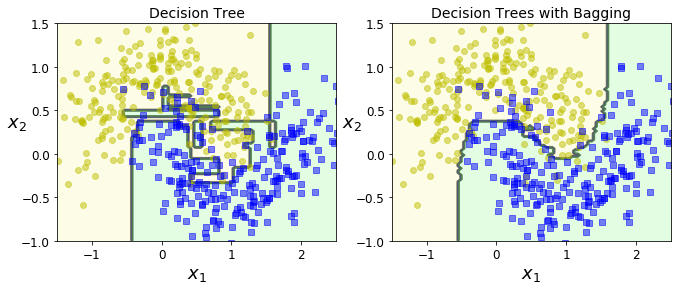

In [8]:
plt.figure(figsize=(11,4))
plt.subplot(121)
plot_decision_boundary(tree_clf, X, y)
plt.title("Decision Tree", fontsize=14)
plt.subplot(122)
plot_decision_boundary(bag_clf, X, y)
plt.title("Decision Trees with Bagging", fontsize=14)
plt.savefig("decision_tree_without_and_with_bagging_plot")
plt.show()

# 右の方が決定境界が非常にうまく汎化性能が高い

In [ ]:
# バギングによるOOB検証
# バギングではサンプリングの重複が認められているため一部のインスタンスが重複、一部のインスタンスが使われないことがある
# この使われないインスタンスを検証に使うことができる。それをOOB検証という　大体37%ほどが使われないインスタンスになる

In [9]:
# OOB検証するには　BaggingClassifier　作成時に　oob_score=True　とする
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(random_state=42), n_estimators=500,
    bootstrap=True, n_jobs=-1, oob_score=True, random_state=40)
bag_clf.fit(X_train, y_train)
bag_clf.oob_score_
# 使われないインスタンスで検証すると0.900程度のスコアになった

0.9013333333333333

In [10]:
# 上記と実際のテストデータスコアを比べてみる
from sklearn.metrics import accuracy_score
y_pred = bag_clf.predict(X_test)
accuracy_score(y_test, y_pred)
# 0.912と近いスコアになった

0.912